In [36]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

In [37]:
# get data
# hsx
df = pd.read_csv('CafeF.HSX.Upto29.03.2019.csv')
# vn30 ky 1 2019
frames = [df[df['<Ticker>']== 'CMG']]
cmg = pd.concat(frames)

In [38]:
data = cmg[::-1]
data.set_index('<DTYYYYMMDD>', inplace = True)
data.drop(['<Ticker>'], inplace=True, axis = 1)
data.index = pd.to_datetime(data.index.astype(str), format = '%Y%m%d')
data.head()

/Users/nhatson/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,<Open>,<High>,<Low>,<Close>,<Volume>
<DTYYYYMMDD>,,,,,
2010-01-22,24.9795,24.9795,20.3405,24.9803,117370
2010-01-25,23.7662,23.7662,23.7662,23.7669,5280
2010-01-26,22.6243,22.6243,22.6243,22.6250,32860
2010-01-27,21.5537,21.5537,21.5537,21.5544,7740
2010-01-28,20.4832,20.4832,20.4832,20.4838,2490


In [39]:
target_col = '<Close>'

In [40]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [41]:
train, test = train_test_split(data, test_size=0.1)

In [42]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

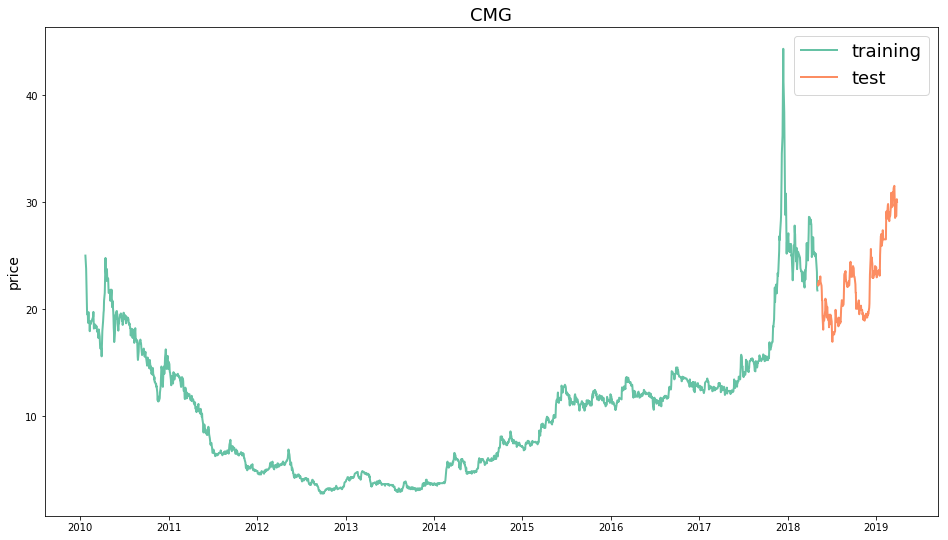

In [43]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='CMG')

In [44]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [51]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [52]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [53]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
2041/2041 [==============================] - 4s 2ms/step - loss: 0.0605
Epoch 2/50
2041/2041 [==============================] - 4s 2ms/step - loss: 0.0375
Epoch 3/50
2041/2041 [==============================] - 3s 1ms/step - loss: 0.0319
Epoch 4/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0301
Epoch 5/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0293
Epoch 6/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0278
Epoch 7/50
2041/2041 [==============================] - 4s 2ms/step - loss: 0.0271
Epoch 8/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0266
Epoch 9/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0254
Epoch 10/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0270
Epoch 11/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0256
Epoch 12/50
2041/2041 [==============================] - 3s 2ms/step - loss: 0.0263
E

In [54]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [55]:
mean_absolute_error(preds, y_test)

0.021407736722331802

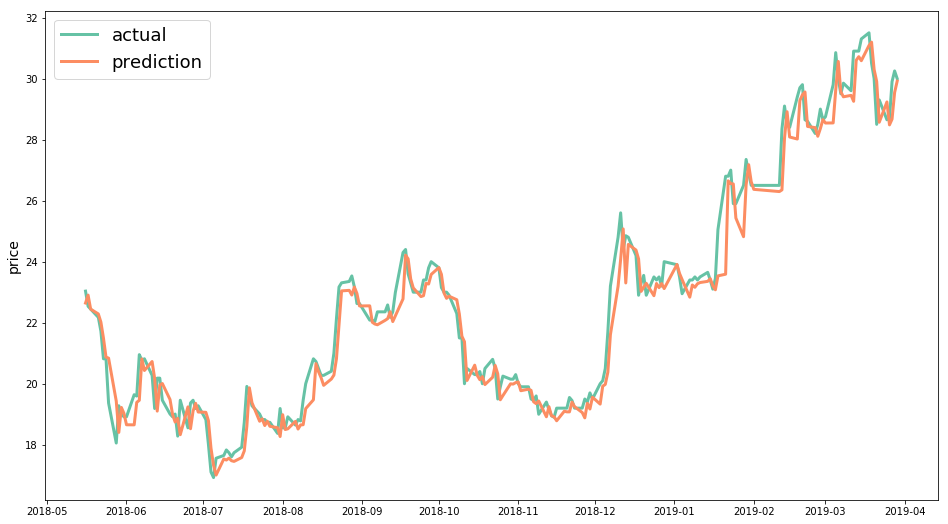

In [56]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

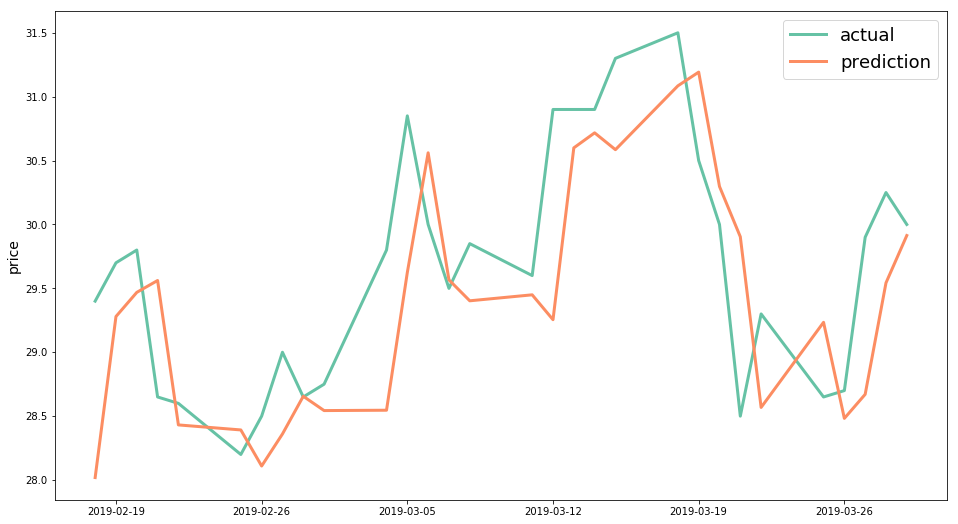

In [57]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

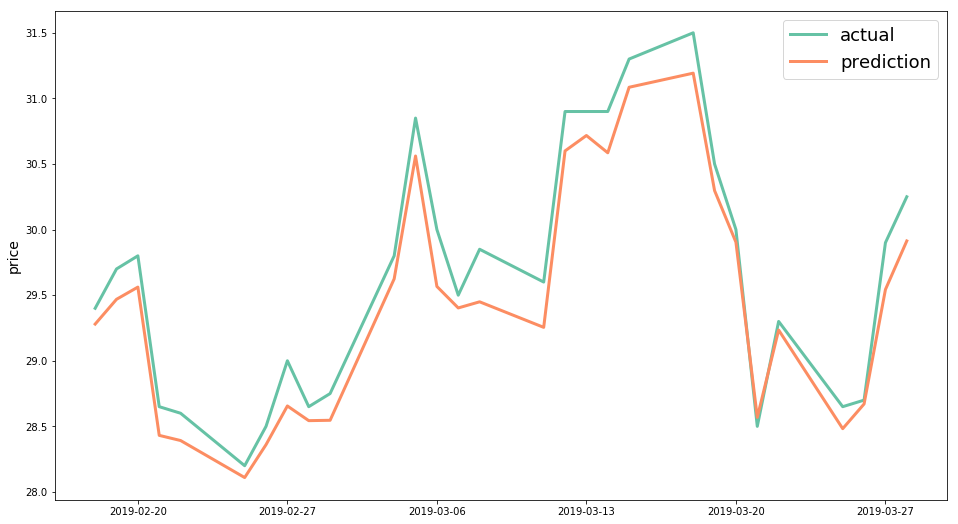

In [58]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

In [60]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [61]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

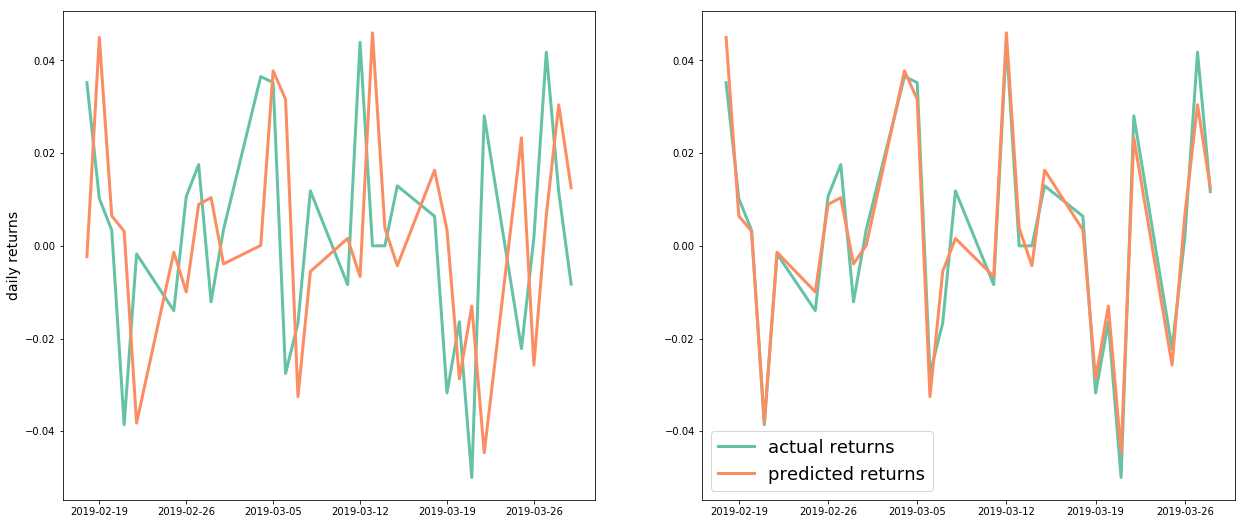

In [63]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

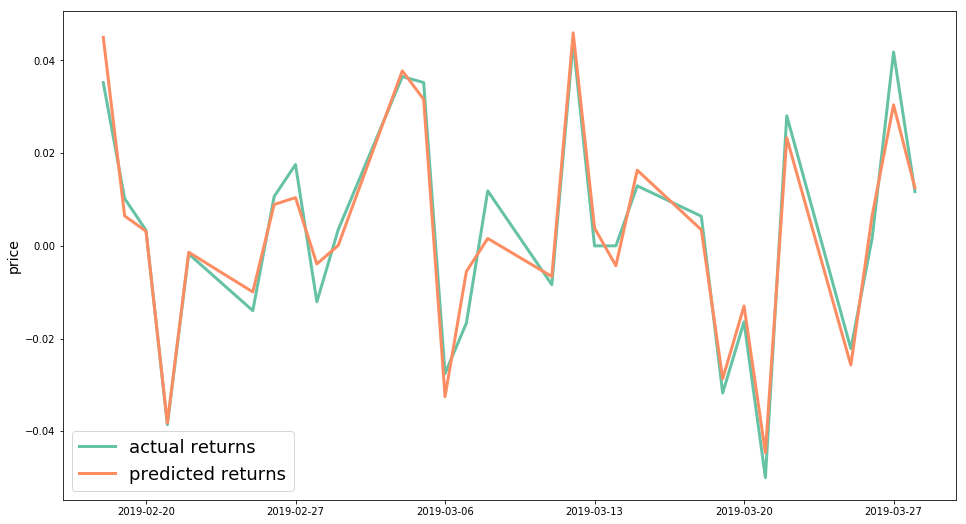

In [64]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

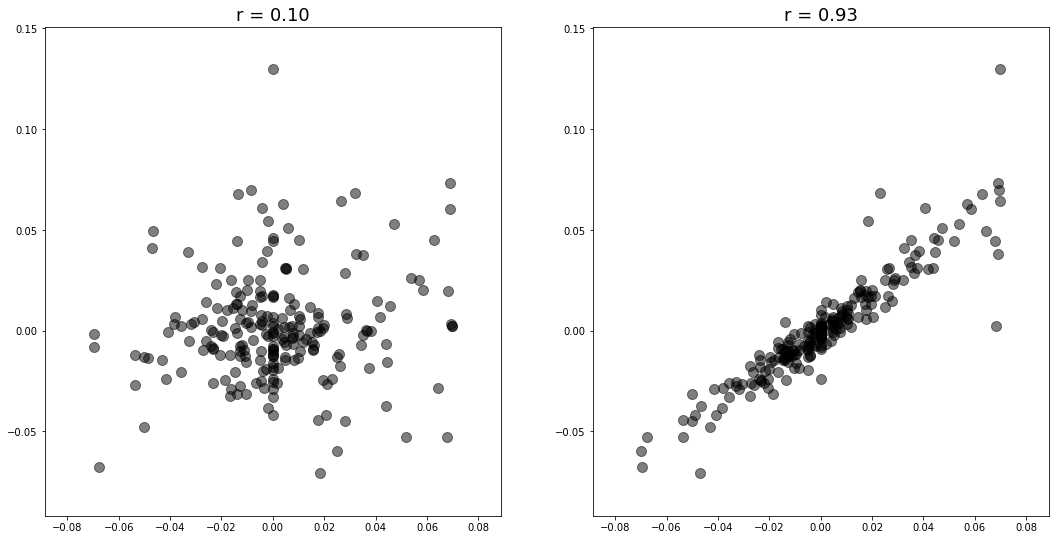

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);